In [58]:
library(data.table)
library(glmnet)
library(ggplot2)
library(lubridate, quietly=TRUE)
library(zoo, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(GGally, quietly=TRUE)
library(caTools)
library(rpart)
library(rattle)
library(caret)
library(e1071)
library(randomForest)
library(gbm)

### Performance Function

In [4]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

# Blog Comment Dataset

This data originates from blog posts. The raw HTML-documents
of the blog posts were crawled and processed.
The prediction task associated with the data is the prediction
of the number of comments in the upcoming 24 hours. In order
to simulate this situation, we choose a basetime (in the past)
and select the blog posts that were published at most
72 hours before the selected base date/time. Then, we calculate
all the features of the selected blog posts from the information
that was available at the basetime, therefore each instance
corresponds to a blog post. The target is the number of
comments that the blog post received in the next 24 hours
relative to the basetime.

In the train data, the basetimes were in the years
2010 and 2011. In the test data the basetimes were
in February and March 2012. This simulates the real-world
situtation in which training data from the past is available
to predict events in the future.

The train data was generated from different basetimes that may
temporally overlap. Therefore, if you simply split the train
into disjoint partitions, the underlying time intervals may
overlap. Therefore, the you should use the provided, temporally
disjoint train and test splits in order to ensure that the
evaluation is fair.


Attribute Information:

1...50:
Average, standard deviation, min, max and median of the
Attributes 51...60 for the source of the current blog post
With source we mean the blog on which the post appeared.
For example, myblog.blog.org would be the source of
the post myblog.blog.org/post_2010_09_10
51: Total number of comments before basetime
52: Number of comments in the last 24 hours before the
basetime
53: Let T1 denote the datetime 48 hours before basetime,
Let T2 denote the datetime 24 hours before basetime.
This attribute is the number of comments in the time period
between T1 and T2
54: Number of comments in the first 24 hours after the
publication of the blog post, but before basetime
55: The difference of Attribute 52 and Attribute 53
56...60:
The same features as the attributes 51...55, but
features 56...60 refer to the number of links (trackbacks),
while features 51...55 refer to the number of comments.
61: The length of time between the publication of the blog post
and basetime
62: The length of the blog post
63...262:
The 200 bag of words features for 200 frequent words of the
text of the blog post
263...269: binary indicator features (0 or 1) for the weekday
(Monday...Sunday) of the basetime
270...276: binary indicator features (0 or 1) for the weekday
(Monday...Sunday) of the date of publication of the blog
post
277: Number of parent pages: we consider a blog post P as a
parent of blog post B, if B is a reply (trackback) to
blog post P.
278...280:
Minimum, maximum, average number of comments that the
parents received
281: The target: the number of comments in the next 24 hours
(relative to basetime)

### Loading Dataset

In [5]:
blog_data=read.csv("blogData_train.csv")
setnames(blog_data,"X1.0.2", "target")

In [6]:
blog_data=as.data.table(blog_data)
blog_data=blog_data[0:10000]
blog_data=na.omit(blog_data)
str(blog_data)

Classes 'data.table' and 'data.frame':	10000 obs. of  281 variables:
 $ X40.30467   : num  40.3 40.3 40.3 40.3 40.3 ...
 $ X53.845657  : num  53.8 53.8 53.8 53.8 53.8 ...
 $ X0.0        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X401.0      : num  401 401 401 401 401 401 401 401 401 401 ...
 $ X15.0       : num  15 15 15 15 15 15 15 15 15 15 ...
 $ X15.52416   : num  15.5 15.5 15.5 15.5 15.5 ...
 $ X32.44188   : num  32.4 32.4 32.4 32.4 32.4 ...
 $ X0.0.1      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X377.0      : num  377 377 377 377 377 377 377 377 377 377 ...
 $ X3.0        : num  3 3 3 3 3 3 3 3 3 3 ...
 $ X14.044226  : num  14 14 14 14 14 ...
 $ X32.615417  : num  32.6 32.6 32.6 32.6 32.6 ...
 $ X0.0.2      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X377.0.1    : num  377 377 377 377 377 377 377 377 377 377 ...
 $ X2.0        : num  2 2 2 2 2 2 2 2 2 2 ...
 $ X34.567566  : num  34.6 34.6 34.6 34.6 34.6 ...
 $ X48.475178  : num  48.5 48.5 48.5 48.5 48.5 ...
 $ X0.0.3      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 

In [7]:
set.seed(35)
spl=sample.split(blog_data$target, SplitRatio = 0.8)
blog_train=subset(blog_data,spl==TRUE)
blog_test=subset(blog_data,spl==FALSE)

## Penalized Regression Approaches(PRA)

### L1 Penalty with Mean Square Error measure

In order to tune lambda values, glmnet packages are used to get best lambda values for Penalized Regression. 

In [8]:
train_mat_blog=data.matrix(blog_train[complete.cases(blog_train),-c("target"),with=F])

result_vec_blog=as.vector(t(blog_train[complete.cases(blog_train),"target"]))

cvfit_blog=cv.glmnet(train_mat_blog,result_vec_blog,family="gaussian",nfolds = 10,type.measure = "mse")

test_mat_blog=data.matrix(blog_test[complete.cases(blog_test),-c("target")])

lasso_model_blog_mse_min <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog$lambda.min, standardize = FALSE)
lasso_model_blog_mse_1se <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog$lambda.1se, standardize = FALSE)
lasso_model_blog_mse_10th <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog$lambda[10], standardize = FALSE)

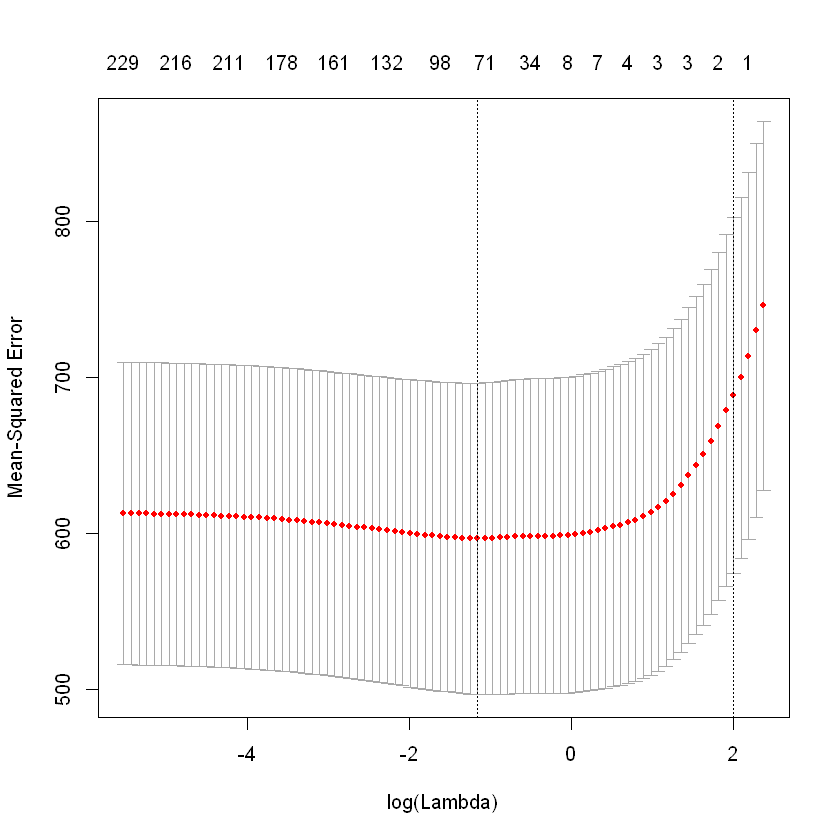

In [9]:
plot(cvfit_blog)

### Lambda Values for Mean Square Error Values

In [10]:
cvfit_blog$lambda.min

[1] 0.3152804

In [11]:
cvfit_blog$lambda.1se

[1] 7.454773

In [12]:
cvfit_blog$lambda[10]

[1] 4.681814

3 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by package by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [13]:
prediction_pra_mse_blog_min <- predict(lasso_model_blog_mse_min, s = cvfit_blog$lambda.min, newx = test_mat_blog)
prediction_pra_mse_blog_1se <- predict(lasso_model_blog_mse_1se, s = cvfit_blog$lambda.1se, newx = test_mat_blog)
prediction_pra_mse_blog_10th <- predict(lasso_model_blog_mse_10th, s = cvfit_blog$lambda[10], newx = test_mat_blog)

## L1 Penalty with Mean Absolute Error measure

In [14]:
train_mat_blog=data.matrix(blog_train[complete.cases(blog_train),-c("target"),with=F])

result_vec_blog=as.vector(t(blog_train[complete.cases(blog_train),"target"]))

cvfit_blog_mae=cv.glmnet(train_mat_blog,result_vec_blog,family="gaussian",nfolds = 10,type.measure = "mae")

test_mat_blog=data.matrix(blog_test[complete.cases(blog_test),-c("target")])

lasso_model_blog_mae_min <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog_mae$lambda.min, standardize = FALSE)
lasso_model_blog_mae_1se <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog_mae$lambda.1se, standardize = FALSE)
lasso_model_blog_mae_10th <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog_mae$lambda[10], standardize = FALSE)

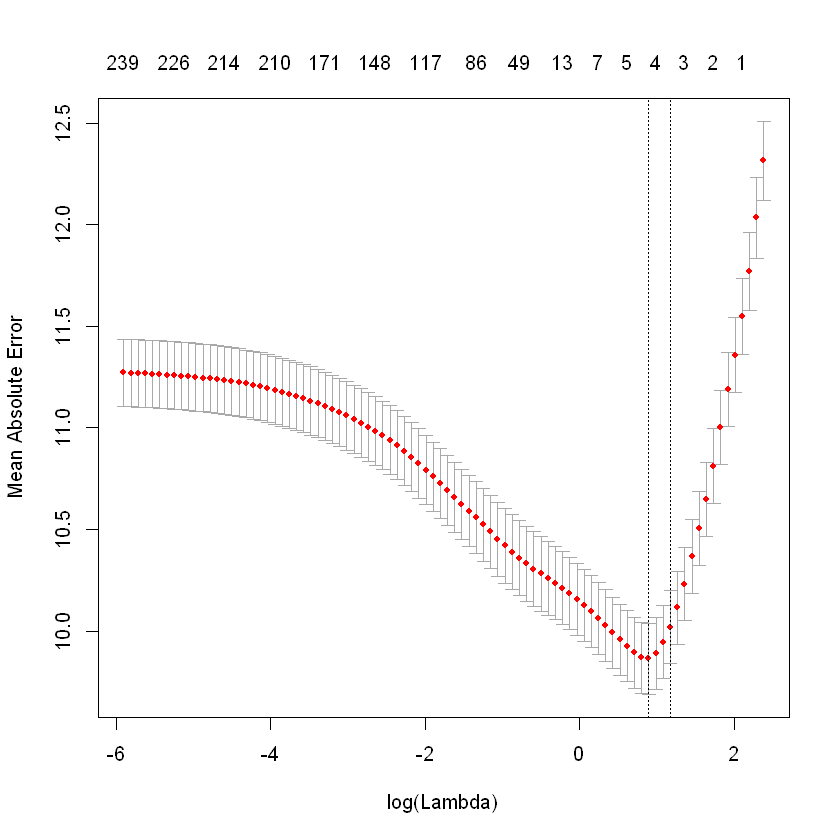

In [15]:
plot(cvfit_blog_mae)

### Lambda Values for Mean Square Error Values

In [16]:
cvfit_blog_mae$lambda.min

[1] 2.441102

In [17]:
cvfit_blog_mae$lambda.1se

[1] 3.226993

In [18]:
cvfit_blog_mae$lambda[10]

[1] 4.681814

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [19]:
prediction_pra_mae_blog_min <- predict(lasso_model_blog_mae_min, s = cvfit_blog_mae$lambda.min, newx = test_mat_blog)
prediction_pra_mae_blog_1se <- predict(lasso_model_blog_mae_1se, s = cvfit_blog_mae$lambda.1se, newx = test_mat_blog)
prediction_pra_mae_blog_10th <- predict(lasso_model_blog_mae_10th, s = cvfit_blog_mae$lambda[10], newx = test_mat_blog)

### Performance Measure for Lasso Regression

In [20]:
perf_dt("Blog Data Set for Lasso Function with min lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_min)
perf_dt("Blog Data Set for Lasso Function with 1se lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_1se)
perf_dt("Blog Data Set for Lasso Function with 10th lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_10th)

perf_dt("Blog Data Set for Lasso Function with min lambda and mae objective", as.numeric(blog_test$target), prediction_pra_mae_blog_min)
perf_dt("Blog Data Set for Lasso Function with 1se lambda and mae objective", as.numeric(blog_test$target), prediction_pra_mae_blog_1se)
perf_dt("Blog Data Set for Lasso Function with 10th lambda and mae objective", as.numeric(blog_test$target), prediction_pra_mae_blog_10th)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with min lambda and mse objective,1977,7.152757,16.66787,-0.2243988,Inf,0.3313882,8.906574,1.245195


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 1se lambda and mse objective,1977,7.152757,16.66787,-0.2301968,Inf,0.3298626,8.726155,1.219971


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 10th lambda and mse objective,1977,7.152757,16.66787,-0.2276585,Inf,0.33034,8.790585,1.228979


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with min lambda and mae objective,1977,7.152757,16.66787,-0.2257989,Inf,0.3308737,8.852091,1.237578


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 1se lambda and mae objective,1977,7.152757,16.66787,-0.2264184,Inf,0.3306597,8.827931,1.2342


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 10th lambda and mae objective,1977,7.152757,16.66787,-0.2276585,Inf,0.33034,8.790585,1.228979


### Glmnet with Caret Library

In [21]:
fitControl=trainControl(method = "repeatedcv",
                           number = 10) 

In order to compare obtained result with resamples function, the same process will be made with caret() library. 

In [22]:
lambda_grid <- expand.grid(alpha = 1, lambda = c(cvfit_blog_mae$lambda.min,
                                                 cvfit_blog_mae$lambda.1se,
                                                 cvfit_blog_mae$lambda[10]))

In [23]:
lm_model <- train(target ~ ., data = blog_train, method = "glmnet", 
                   trControl = fitControl, tuneGrid = lambda_grid)

glmnet 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7221, 7220, 7220, 7220, 7222, 7220, ... 
Resampling results across tuning parameters:

  lambda    RMSE      Rsquared   MAE      
  2.441102  24.42847  0.2050926   9.869664
  3.226993  24.61889  0.2009448  10.022668
  4.681814  25.07599  0.1863053  10.510031

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 2.441102.

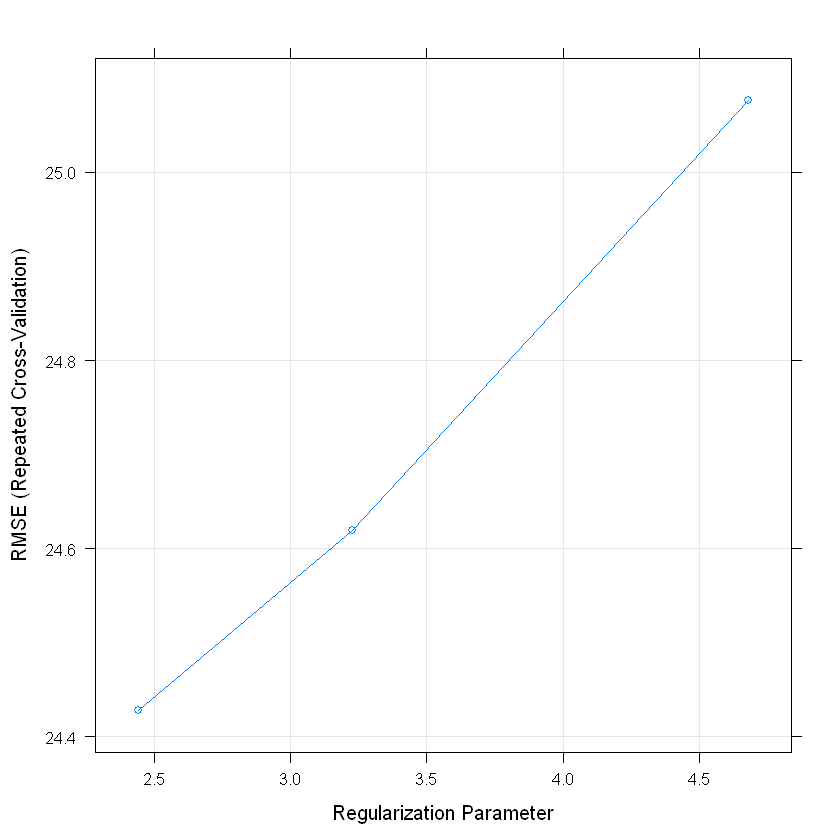

In [24]:
lm_model
plot(lm_model)

## Decision Tree(DT)

In [25]:
set.seed(35)

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7222, 7220, 7221, 7220, 7220, 7221, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.19199  0.3853273   7.603728
  0.01  23.39357  0.2852710   8.856399
  0.02  23.45041  0.2620904   9.370173
  0.03  23.47057  0.2560673   9.483803
  0.04  24.00953  0.2217356   9.657709
  0.05  24.46023  0.1884401   9.994240
  0.06  24.72126  0.1710733  10.129938
  0.07  25.31053  0.1284348  10.426885
  0.08  25.29362  0.1299611  10.451589
  0.09  25.29362  0.1299611  10.451589
  0.10  25.29362  0.1299611  10.451589

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.
CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7222, 7220, 7220, 7221, 7221, 7221, ... 
Resampling resul

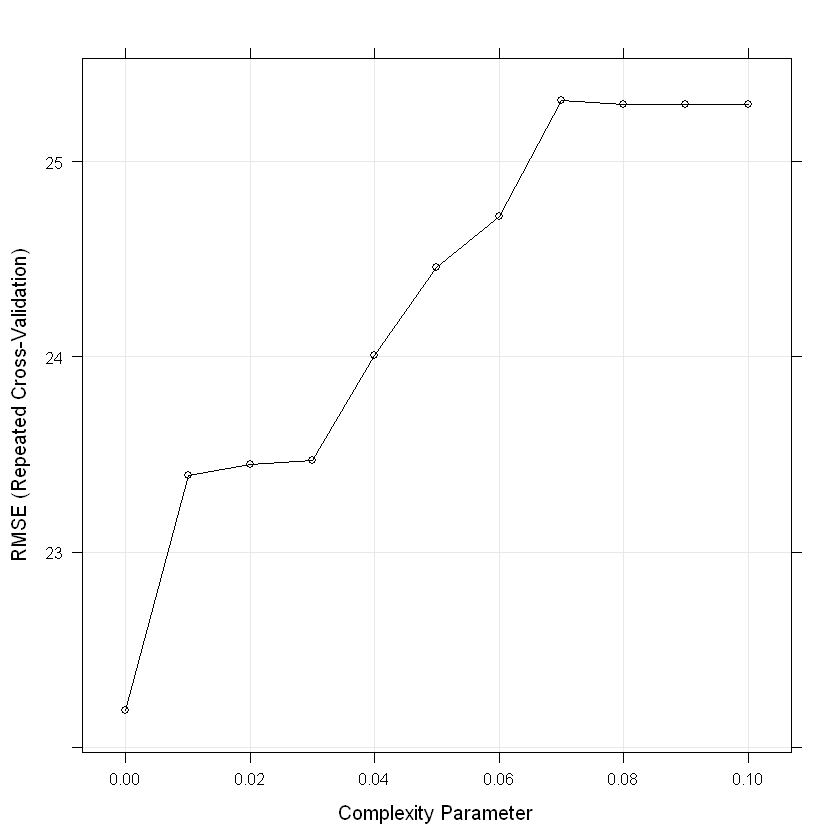

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7220, 7220, 7220, 7221, 7221, 7221, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.41309  0.3566943   7.826263
  0.01  23.17618  0.2900864   8.809889
  0.02  23.37807  0.2760738   9.219326
  0.03  23.58675  0.2577259   9.431677
  0.04  23.95065  0.2335036   9.506912
  0.05  24.37008  0.2006009   9.834922
  0.06  25.19986  0.1465266  10.291834
  0.07  25.46280  0.1255471  10.445302
  0.08  25.46280  0.1255471  10.445302
  0.09  25.46280  0.1255471  10.445302
  0.10  25.46280  0.1255471  10.445302

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


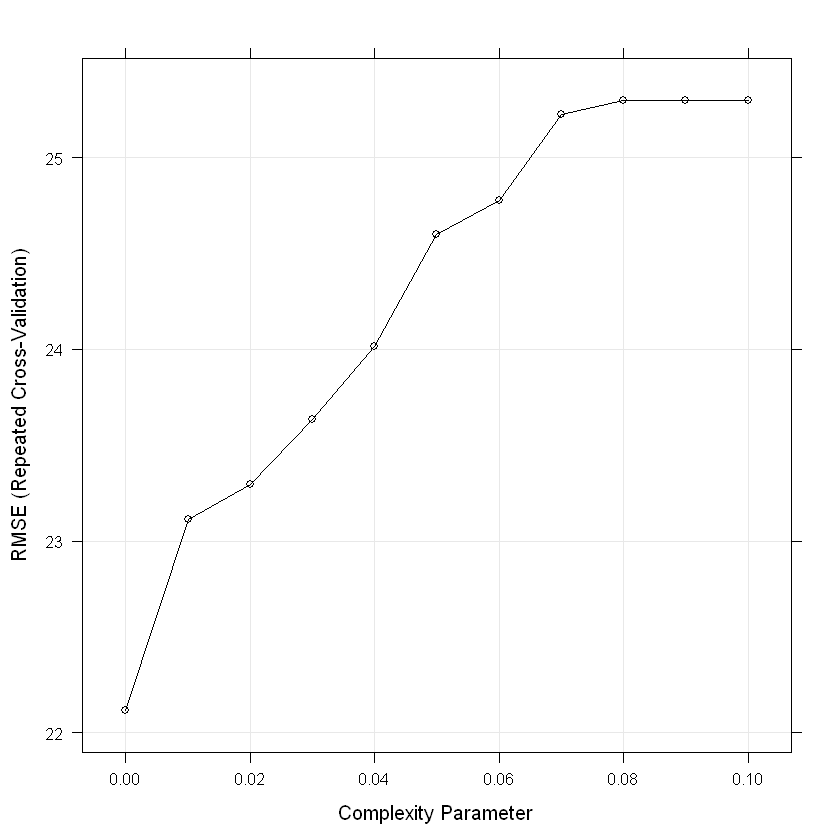

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7221, 7221, 7221, 7221, 7220, 7220, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.34826  0.3582948   7.950214
  0.01  23.22672  0.2871459   8.802480
  0.02  23.37998  0.2721888   9.315961
  0.03  23.33501  0.2758044   9.383709
  0.04  24.23808  0.2120166   9.702696
  0.05  24.32628  0.2002152   9.935582
  0.06  24.65797  0.1802512  10.049736
  0.07  25.31352  0.1309855  10.337748
  0.08  25.29457  0.1316937  10.404182
  0.09  25.29457  0.1316937  10.404182
  0.10  25.29457  0.1316937  10.404182

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


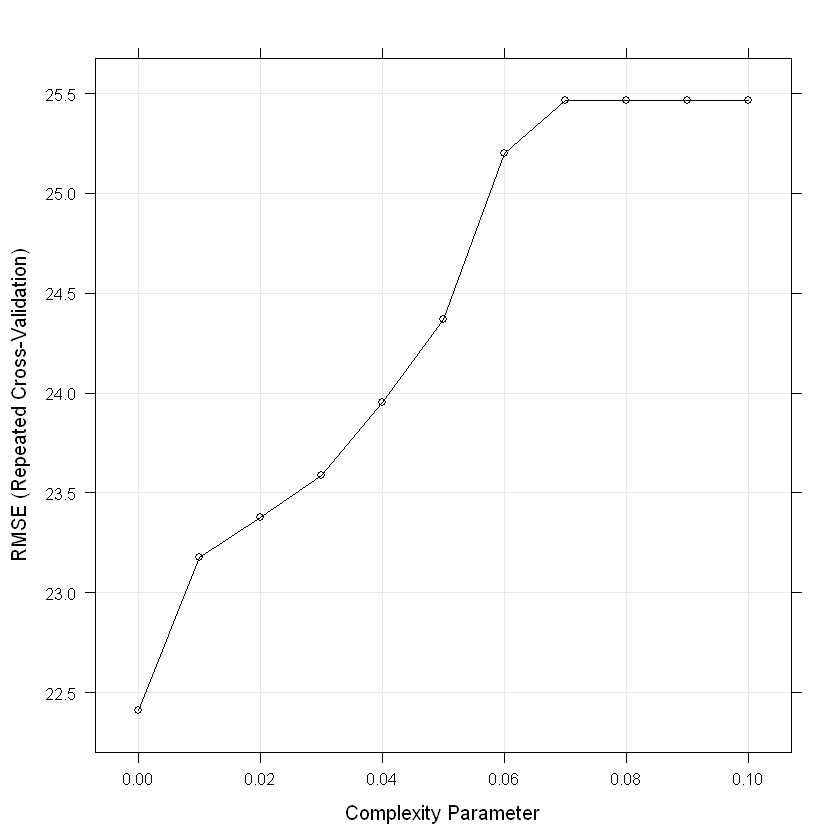

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7221, 7221, 7221, 7222, 7221, 7220, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.05051  0.3740397   7.943829
  0.01  23.35699  0.2840902   8.843194
  0.02  23.65451  0.2583118   9.267911
  0.03  23.61097  0.2554079   9.405995
  0.04  24.23950  0.2144014   9.628656
  0.05  24.68917  0.1821829   9.980277
  0.06  25.08616  0.1558009  10.162702
  0.07  25.49545  0.1259631  10.325817
  0.08  25.53129  0.1246686  10.415070
  0.09  25.53129  0.1246686  10.415070
  0.10  25.53129  0.1246686  10.415070

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


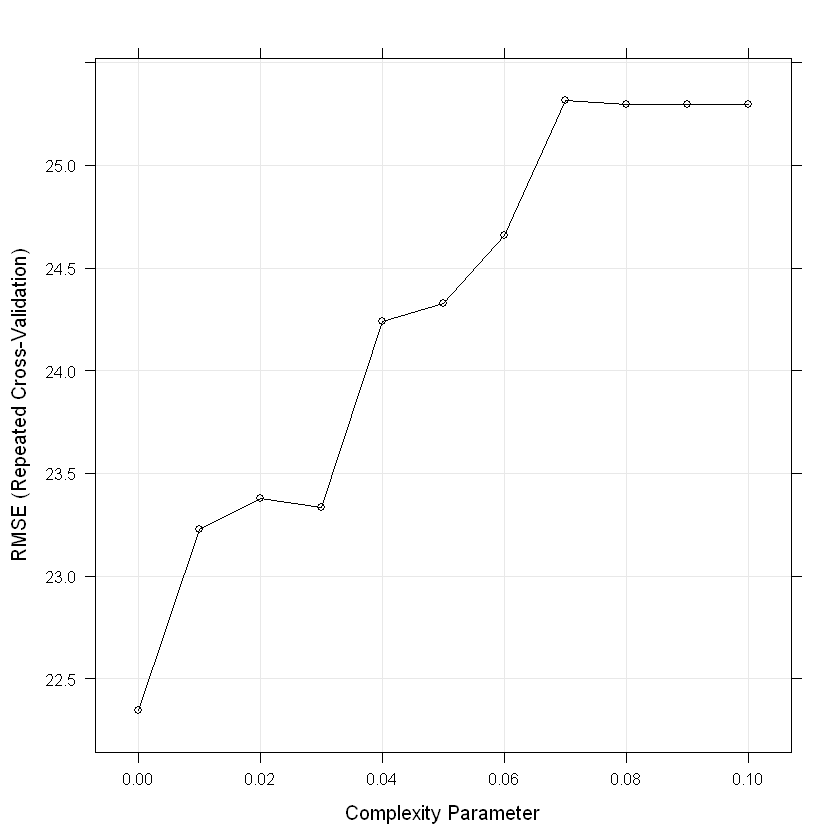

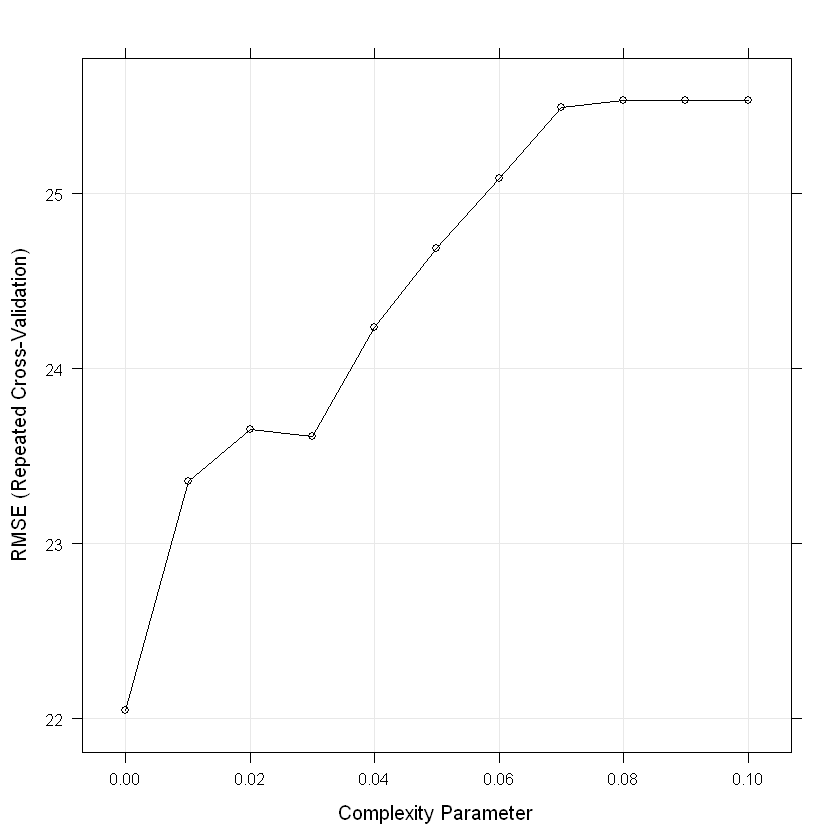

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7220, 7221, 7221, 7221, 7221, 7220, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.40235  0.3457160   7.854748
  0.01  23.44146  0.2726905   8.791024
  0.02  23.52858  0.2594959   9.278822
  0.03  23.59981  0.2496713   9.394675
  0.04  24.12738  0.2171165   9.574562
  0.05  24.41028  0.1974758   9.940318
  0.06  24.85231  0.1673103  10.049114
  0.07  25.28040  0.1341191  10.321568
  0.08  25.38610  0.1280509  10.411522
  0.09  25.38610  0.1280509  10.411522
  0.10  25.38610  0.1280509  10.411522

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


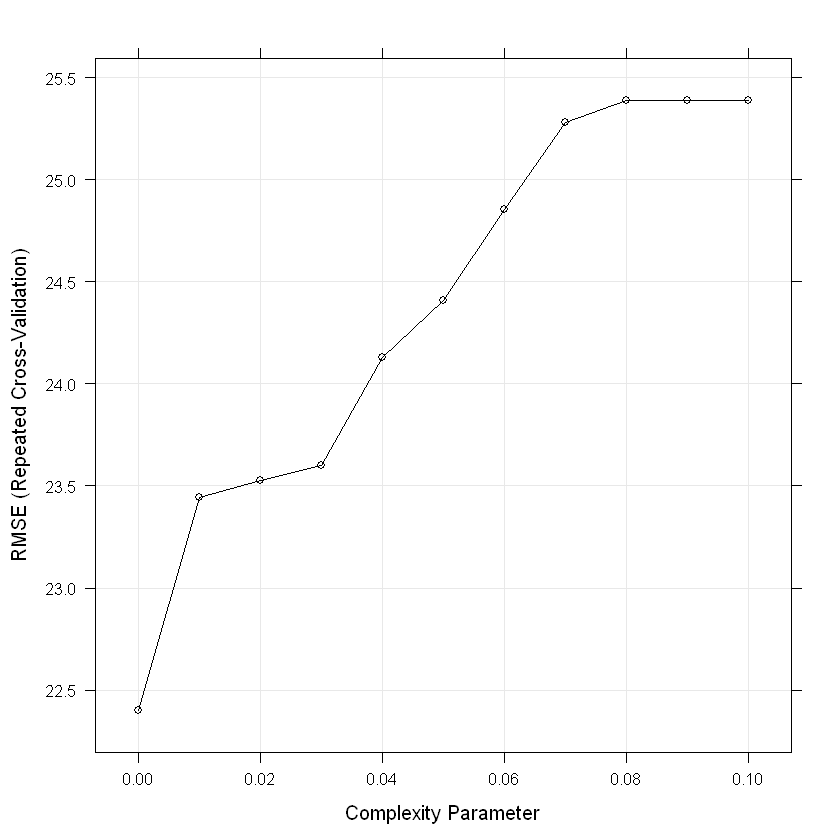

In [26]:
cpGrid=expand.grid(.cp=(0:10)*0.01)
for(i in 5:10){
    tr=train(target~.,
          data=blog_train, 
          method="rpart",
          trControl=fitControl,
          tuneGrid= cpGrid,
            # minbucket=minbucket_grid
           control= rpart.control(minbucket = i)
            )
    trellis.par.set(caretTheme())
    print(plot(tr))    
    print(tr)
}

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7220, 7220, 7221, 7222, 7221, 7220, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.57559  0.3897072   7.384471
  0.01  23.31100  0.2881720   8.693458
  0.02  23.59941  0.2619470   9.289978
  0.03  23.57051  0.2572654   9.434858
  0.04  24.22841  0.2119279   9.718694
  0.05  24.51101  0.1872444   9.984797
  0.06  24.51033  0.1872444   9.990837
  0.07  25.27038  0.1352021  10.349000
  0.08  25.27885  0.1329492  10.415419
  0.09  25.27885  0.1329492  10.415419
  0.10  25.27885  0.1329492  10.415419

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


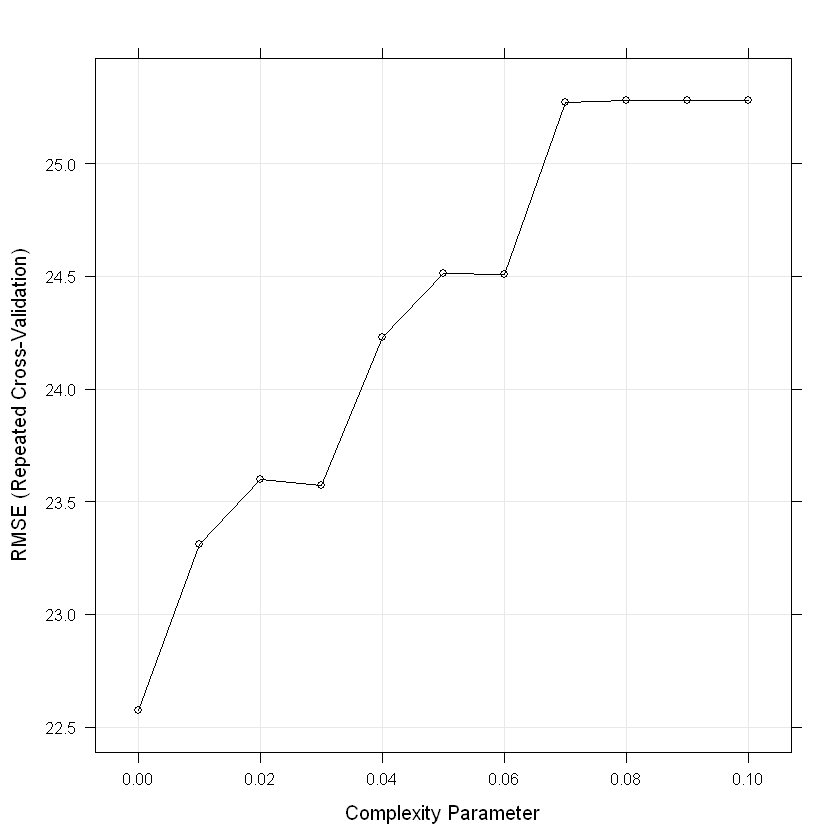

In [27]:
cpGrid=expand.grid(.cp=(0:10)*0.01)
tr_last=train(target~.,
      data=blog_train, 
      method="rpart",
      trControl=fitControl,
      tuneGrid= cpGrid,
       control= rpart.control(minsplit = 8)
        )
trellis.par.set(caretTheme())
print(plot(tr_last))    
print(tr_last)

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

X2.0.4       X2.0.2      X10.0.1       X2.0.3       X2.0.1       X401.0 
1.550799e+06 1.403887e+06 1.127240e+06 8.807718e+05 8.767315e+05 4.406184e+05 
     X0.0.20    X15.52416    X32.44188        X15.0       X377.0   X14.044226 
4.363726e+05 4.253001e+05 4.083654e+05 3.908218e+05 3.661818e+05 2.396487e+05 
  X53.845657    X40.30467      X0.0.14         X3.0     X0.0.152      X.356.0 
2.133779e+05 1.489814e+05 1.476480e+05 1.187315e+05 1.062761e+05 9.772878e+04 
    X0.0.129      X0.0.27      X0.0.25     X0.0.165         X2.0      X0.0.80 
9.192272e+04 9.087635e+04 9.033122e+04 8.585505e+04 7.904684e+04 7.001978e+04 
     X0.0.37     X0.0.101     X0.0.204       X1.0.1   X48.475178     X0.0.224 
6.844944e+04 6.796432e+04 6.225738e+04 6.171861e+04 5.804078e+04 5.803387e+04 
     X0.0.86     X0.0.206     X0.0.142   X1.4799345      X0.0.30        X12.0 
5.772826e+04 5.436067e+04 5.327601e+04 5.228931e+04 5.129957e+04 5.060618e+04 
       X11.0     X0.0.184      X0.0.59    X1.795416   X1.0761671     X0.0.227 
5.060588e+04 4.928493e+04 4.656397e+04 4.566495e+04 4.557990e+04 4.411163e+04 
     X0.0.97     X0.0.191     X0.0.221     X0.0.232     X0.0.223     X0.0.109 
4.283016e+04 4.242507e+04 4.117038e+04 4.113104e+04 4.084925e+04 4.060461e+04 
    X0.0.190     X0.0.230     X0.0.225     X0.0.226     X0.0.111      X0.0.60 
3.583682e+04 3.573132e+04 3.520417e+04 3.295404e+04 3.292394e+04 3.271088e+04 
     X0.0.19     X0.0.228      X0.0.93     X0.0.139      X0.0.62     X0.0.222 
3.133450e+04 2.926939e+04 2.775267e+04 2.768668e+04 2.611934e+04 2.576617e+04 
    X0.0.215      X0.0.16     X0.0.231     X0.0.171     X0.0.117      X0.0.72 
2.519125e+04 2.440774e+04 2.430111e+04 2.426441e+04 2.240009e+04 2.187438e+04 
    X0.0.229      X0.0.98      X0.0.54      X0.0.78     X0.0.160      X0.0.77 
2.186766e+04 2.181955e+04 2.152707e+04 1.868576e+04 1.828481e+04 1.816604e+04 
     X0.0.35     X0.0.128      X0.0.94      X0.0.40     X0.0.186     X0.0.112 
1.804820e+04 1.773188e+04 1.767895e+04 1.729243e+04 1.711291e+04 1.591098e+04 
     X0.0.61     X0.0.138      X0.0.26      X0.0.99      X0.0.44     X0.0.210 
1.584535e+04 1.457788e+04 1.405460e+04 1.398649e+04 1.369785e+04 1.348740e+04 
     X0.0.79      X0.0.22     X0.0.151   X34.567566     X0.0.168      X0.0.63 
1.306951e+04 1.259033e+04 1.234982e+04 1.224512e+04 1.217895e+04 1.154961e+04 
     X0.0.33     X0.0.153     X0.0.116     X0.0.203    X0.972973     X0.0.213 
1.135319e+04 1.070669e+04 1.007610e+04 9.697752e+03 9.616374e+03 9.289333e+03 
    X0.0.199     X0.0.141      X0.0.74      X0.0.92     X0.0.133     X0.0.132 
9.181308e+03 9.055690e+03 9.030331e+03 8.870687e+03 8.847925e+03 8.572789e+03 
    X0.0.145      X0.0.15     X0.0.192       X0.0.4        X10.0     X0.0.174 
7.534488e+03 7.459155e+03 6.955035e+03 6.814320e+03 6.647351e+03 6.632451e+03 
        X9.0     X0.0.188      X0.0.68         X1.0      X0.0.73      X0.0.95 
6.467413e+03 6.248313e+03 6.022759e+03 5.928965e+03 5.877875e+03 5.669603e+03 
    X0.0.179      X0.0.46     X0.0.118      X0.0.18     X0.0.150      X0.0.28 
5.668790e+03 5.580115e+03 5.154798e+03 5.100932e+03 5.090043e+03 5.087327e+03 
    X0.0.205       X9.0.1       X9.0.2      X0.0.83      X0.0.85     X0.0.105 
4.974990e+03 4.681734e+03 4.678867e+03 4.602952e+03 4.466381e+03 4.190260e+03 
    X0.0.155     X0.0.115     X0.0.121     X0.0.180     X0.0.233     X0.0.108 
4.113777e+03 3.990598e+03 3.961893e+03 3.860923e+03 3.635307e+03 2.948209e+03 
    X0.0.144      X0.0.17      X0.0.58      X0.0.96      X0.0.66      X0.0.89 
2.942769e+03 2.878131e+03 2.748412e+03 2.722106e+03 2.691443e+03 2.539261e+03 
    X0.0.149     X0.0.159   X1.0780969      X0.0.47      X0.0.50     X0.0.134 
2.492988e+03 2.473937e+03 2.383447e+03 2.289498e+03 2.282020e+03 2.030403e+03 
       X.8.0   X0.4004914     X0.0.209      X0.0.57     X0.0.169     X0.0.120 
1.961301e+03 1.950686e+03 1.927753e+03 1.911815e+03 1.715783e+03 1.706531e+03 
    X0.0.198      X0.0.32    X1.704671     X0.0.146     

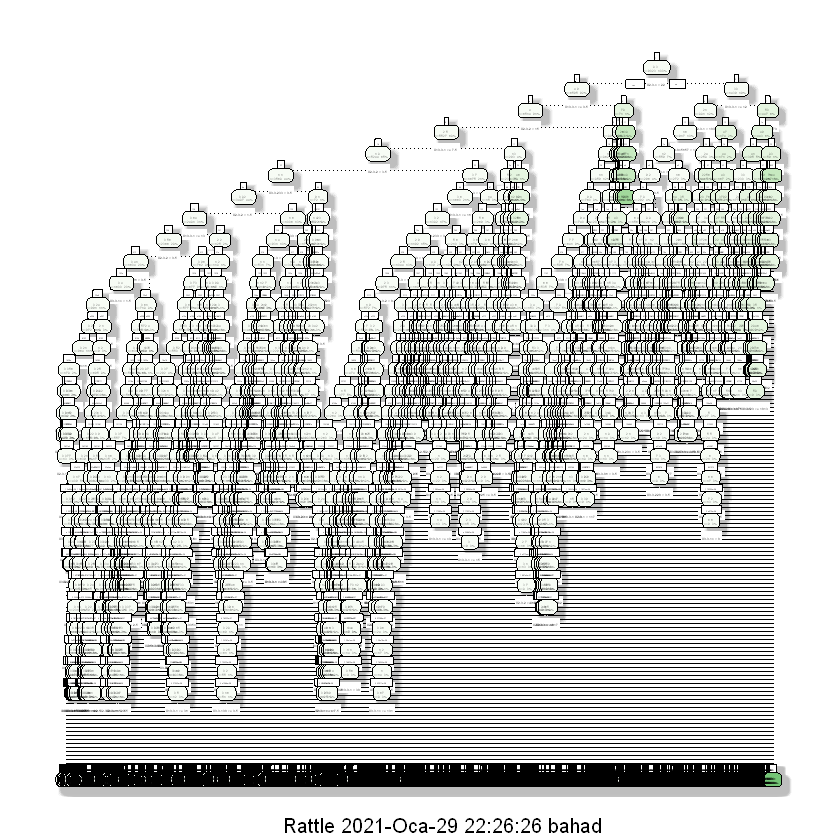

In [28]:
reg_tree_blog=tr_last$finalModel
fancyRpartPlot(reg_tree_blog)
reg_tree_blog$variable.importance

In [29]:
predicted_blog_dt=predict(reg_tree_blog,newdata=blog_test)

### Performanca Measure

In [56]:
perf_dt("Decision Tree with CV for Blog Comment Dataset",blog_test$target,as.numeric(predicted_blog_dt))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Blog Comment Dataset,1977,7.152757,16.66787,-0.211185,NaN,0.3807407,6.082319,0.8503462


## Random Forest(RF)

In [57]:
library(ranger)

In [32]:
rf_grid=expand.grid(mtry=c(4,8,10,15),
                   splitrule = c("variance"),
                   min.node.size= c(5))
rf_grid  

mtry,splitrule,min.node.size
4,variance,5
8,variance,5
10,variance,5
15,variance,5


In [33]:
rf_fit=train(target ~ ., data = blog_train, 
                 method = "ranger", 
                 trControl = fitControl, num.trees=500,
                 tuneGrid = rf_grid) 

Random Forest 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7220, 7221, 7220, 7221, 7221, 7221, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   4    23.12233  0.3410507  9.550554
   8    20.40609  0.4818724  7.921203
  10    19.78936  0.5023333  7.523441
  15    19.20015  0.5178478  6.988483

Tuning parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 15, splitrule = variance
 and min.node.size = 5.

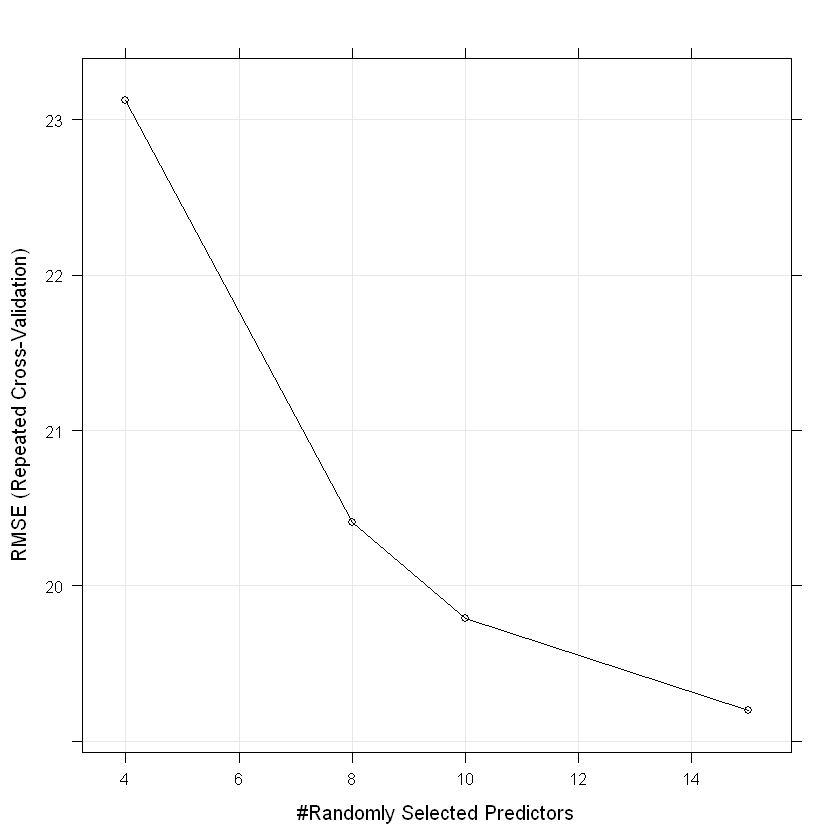

In [34]:
rf_fit
plot(rf_fit)

In [35]:
RandomForest_blog=predict(rf_fit,newdata=blog_test)

### Performanca Measure

In [36]:
perf_dt("First Data Set for Random Forest", as.numeric(blog_test$target), as.numeric(RandomForest_blog))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,1977,7.152757,16.66787,-0.2323384,Inf,0.2484009,5.514749,0.7709963


## Stochastic Gradient Boosting(SGB)

In [37]:
set.seed(35)

In [38]:
blog_train[,X0.0.1:=NULL]
blog_train[,X0.0.2:=NULL]
blog_train[,X0.0.5:=NULL]
blog_train[,X0.0.7:=NULL]
blog_train[,X0.0.8:=NULL]
blog_train[,X0.0.9:=NULL]
blog_train[,X0.0.10:=NULL]
blog_train[,X0.0.11:=NULL]
blog_train[,X0.0.13:=NULL]
blog_train[,X0.0.234:=NULL]

blog_test[,X0.0.1:=NULL]
blog_test[,X0.0.2:=NULL]
blog_test[,X0.0.5:=NULL]
blog_test[,X0.0.7:=NULL]
blog_test[,X0.0.8:=NULL]
blog_test[,X0.0.9:=NULL]
blog_test[,X0.0.10:=NULL]
blog_test[,X0.0.11:=NULL]
blog_test[,X0.0.13:=NULL]
blog_test[,X0.0.234:=NULL]

Stochastic Gradient Boosting 

8023 samples
 270 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7222, 7220, 7221, 7220, 7220, 7221, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  0.1        1                   25      23.51668  0.2849392  9.506556
  0.1        1                   50      22.80351  0.3032841  8.832547
  0.1        1                   75      22.65047  0.3098092  8.775545
  0.1        1                  100      22.63235  0.3104455  8.889400
  0.1        1                  125      22.61024  0.3117079  8.963804
  0.1        3                   25      21.73289  0.3743305  8.388996
  0.1        3                   50      21.29655  0.3899361  8.003750
  0.1        3                   75      21.22808  0.3937943  7.952887
  0.1        3                  100      21.24836  0.3933181  7.957694
  0.1        3                  125      21

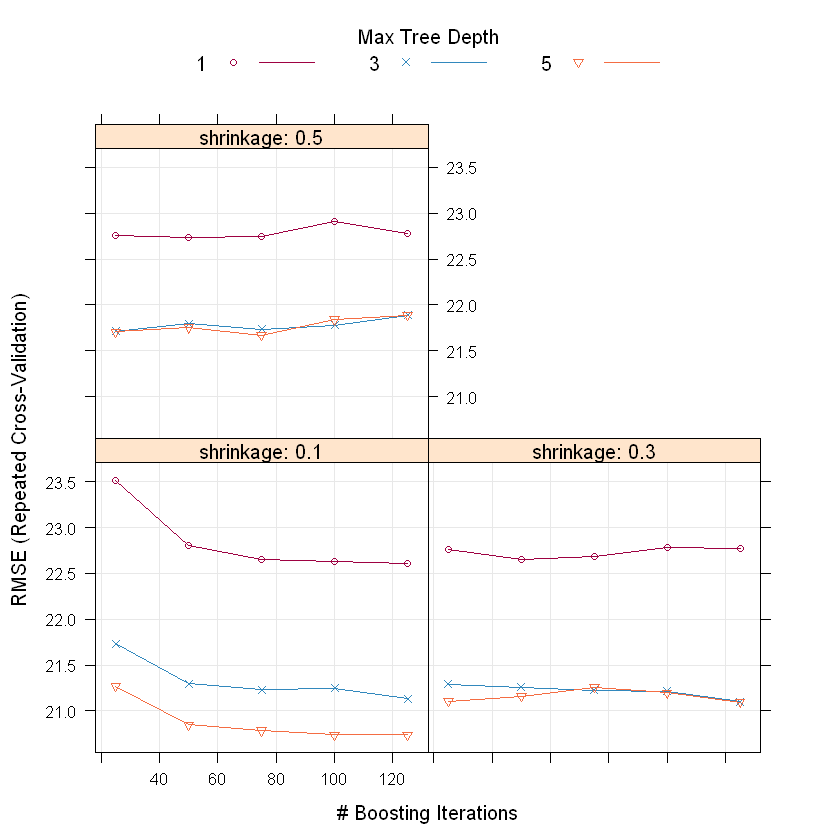

In [39]:
gbmGrid=expand.grid(interaction.depth = c(1, 3, 5), 
                        n.trees = (1:5)*25, 
                        shrinkage = c(0.1, 0.3, 0.5),
                        n.minobsinnode = 20)
                                                                

gbm_fit=train(target ~ ., data = blog_train, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F)

gbm_fit
plot(gbm_fit)

In [40]:
predicted_blog_sgb=predict(gbm_fit,blog_test)

### Performanca Measure

In [41]:
perf_dt("First Data Set for Stochastic Gradient Boosting",as.numeric(blog_test$target), as.numeric(predicted_blog_sgb))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,1977,7.152757,16.66787,-0.1954518,Inf,0.3035566,6.246727,0.8733313


# General Result for 4 Method for Blog Comment Results

In [54]:
perf_dt("Blog Comment Set for Lasso Function with min lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_1se)
perf_dt("Decision Tree with CV for Blog Comment Dataset",blog_test$target,as.numeric(predicted_blog_dt))
perf_dt("First Data Set for Random Forest", as.numeric(blog_test$target), as.numeric(RandomForest_blog))
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(blog_test$target), as.numeric(predicted_blog_sgb) )

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Comment Set for Lasso Function with min lambda and mse objective,1977,7.152757,16.66787,-0.2301968,Inf,0.3298626,8.726155,1.219971


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Blog Comment Dataset,1977,7.152757,16.66787,-0.211185,NaN,0.3807407,6.082319,0.8503462


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,1977,7.152757,16.66787,-0.2323384,Inf,0.2484009,5.514749,0.7709963


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,1977,7.152757,16.66787,-0.1954518,Inf,0.3035566,6.246727,0.8733313


# Conclusion of Models

## Linear Regression with Penalty

Different Penalty types are tried in the glmnet package by using mean absolute percentage error and mean square error objective. In these 2 penalty, 3 different lambdas are tried to obtain a model. In addition, all the possible lambda values are checked by plotting the cv.glmnet() results. Predictions are made based on these models. Best model performance are observed in this test dataset. After all, caret() packages are used to make a model can be comparable with other method's models. Namely, caret library is used in all the methods to obtain similar report types. Penalized Regression Approach is made with 3 different lambda values. These are lambda.min, lambda.1se, and random a lambda value achieved in the previous cv.glmnet() process. Model results are as follows:

In [43]:
lm_model

glmnet 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7221, 7220, 7220, 7220, 7222, 7220, ... 
Resampling results across tuning parameters:

  lambda    RMSE      Rsquared   MAE      
  2.441102  24.42847  0.2050926   9.869664
  3.226993  24.61889  0.2009448  10.022668
  4.681814  25.07599  0.1863053  10.510031

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 2.441102.

### Best Model for Penalized Regression Approach

RMSE will be the objective parameter for evaluation of the model. In this perpective, **lambda 2.441102(lambda.min) and MAE Penalty type** is the best tuned parameter for this model for Blog Comment Dataset.

In [44]:
print(paste("The Smallest RMSE value in Penalized Regression Approach:",lm_model$results$RMSE[which.min(lm_model$results$RMSE)]))

[1] "The Smallest RMSE value in Penalized Regression Approach: 24.4284740530075"


## Decision Tree

**6 different minbucket** values are tried to get best model for Decision Tree. However, in caret library there is no available packages for rpart for tuning the minimal number of observation per tree leaf. So for loop is tried to get information related to effects in the change of number of variable in the tree leaf. In addition, all models tested with **10 different cp value**. After looking the created model's result, the best model is selected. The best RMSE value is selected with considering the minbucket values and cp values. Selected model evaluated 1 more time and named as tr_last. Model results are as follows:

In [45]:
tr_last

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7220, 7220, 7221, 7222, 7221, 7220, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.57559  0.3897072   7.384471
  0.01  23.31100  0.2881720   8.693458
  0.02  23.59941  0.2619470   9.289978
  0.03  23.57051  0.2572654   9.434858
  0.04  24.22841  0.2119279   9.718694
  0.05  24.51101  0.1872444   9.984797
  0.06  24.51033  0.1872444   9.990837
  0.07  25.27038  0.1352021  10.349000
  0.08  25.27885  0.1329492  10.415419
  0.09  25.27885  0.1329492  10.415419
  0.10  25.27885  0.1329492  10.415419

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.

### Best Model for Decision Tree

RMSE will be the objective parameter for evaluation of the model. In this perpective, **cp=0 and minbucket = 9** is the best tuned parameter for this model for Blog Comment Dataset.

In [46]:
print(paste("The Smallest RMSE value in Decision Tree:",tr_last$results$RMSE[which.min(tr_last$results$RMSE)]))

[1] "The Smallest RMSE value in Decision Tree: 22.5755890810299"


## Random Forest

As mentioned in the homework description, only mtry namely number of selected feature for model is modified. 4 different number is determined. Best model is achived the model with the biggest number of feature. Hovewer, Mean Absolute Error is the smallest in the model with the smallest number of feature. Model results are as follows:

In [47]:
rf_fit

Random Forest 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7220, 7221, 7220, 7221, 7221, 7221, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   4    23.12233  0.3410507  9.550554
   8    20.40609  0.4818724  7.921203
  10    19.78936  0.5023333  7.523441
  15    19.20015  0.5178478  6.988483

Tuning parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 15, splitrule = variance
 and min.node.size = 5.

### Best Model for Random Forest

RMSE will be the objective parameter for evaluation of the model. In this perpective, **mtry=15** is the best tuned parameter for this model for Blog Comment Dataset.

In [48]:
print(paste("The Smallest RMSE value in Random Forest:",rf_fit$results$RMSE[which.min(rf_fit$results$RMSE)]))

[1] "The Smallest RMSE value in Random Forest: 19.2001454757668"


## Stochastic Gradient Boosting

**Different 5 shrinkage value, 3 interaction.depth, 5 n.trees values** are tried to obtain the best model. This model is the one which takes the most time to create the models. The reason behind this fact caused from number of tuned parameter in the approach. However, it has the best RMSE value among the models. Model results are as follows:

In [49]:
gbm_fit

Stochastic Gradient Boosting 

8023 samples
 270 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 7222, 7220, 7221, 7220, 7220, 7221, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  0.1        1                   25      23.51668  0.2849392  9.506556
  0.1        1                   50      22.80351  0.3032841  8.832547
  0.1        1                   75      22.65047  0.3098092  8.775545
  0.1        1                  100      22.63235  0.3104455  8.889400
  0.1        1                  125      22.61024  0.3117079  8.963804
  0.1        3                   25      21.73289  0.3743305  8.388996
  0.1        3                   50      21.29655  0.3899361  8.003750
  0.1        3                   75      21.22808  0.3937943  7.952887
  0.1        3                  100      21.24836  0.3933181  7.957694
  0.1        3                  125      21

### Best Model for Stochastic Gradient Boosting

RMSE will be the objective parameter for evaluation of the model. In this perpective, **n.trees = 125 interaction.depth =
 5, shrinkage = 0.1 and n.minobsinnode = 20** is the best tuned parameter for this model for Number of Blog Dataset.

In [50]:
print(paste("The Smallest RMSE value in Stochastic Gradient Boosting:",gbm_fit$results$RMSE[which.min(gbm_fit$results$RMSE)]))

[1] "The Smallest RMSE value in Stochastic Gradient Boosting: 20.7380054790217"


# Comparision of Results in Training and Test Dataset

In [51]:
train=list("Linear Regression with Lasso Results"=lm_model$results$RMSE[which.min(lm_model$results$RMSE)],
            "Decision Tree Results"=    tr_last$results$RMSE[which.min(tr_last$results$RMSE)],
            "Random Forest Results"=    rf_fit$results$RMSE[which.min(rf_fit$results$RMSE)],
            "Result Stochastic Gradient Boosting Results"=    gbm_fit$results$RMSE[which.min(gbm_fit$results$RMSE)])

## RMSE in The Train Dataset

In [52]:
t(train)

Linear Regression with Lasso Results,Decision Tree Results,Random Forest Results,Result Stochastic Gradient Boosting Results
24.42847,22.57559,19.20015,20.73801


In [55]:
perf_dt("Blog Comment Data Set for Lasso Function with min lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_1se)
perf_dt("Decision Tree with CV for Blog Comment Dataset",blog_test$target,as.numeric(predicted_blog_dt))
perf_dt("First Data Set for Random Forest", as.numeric(blog_test$target), as.numeric(RandomForest_blog))
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(blog_test$target), as.numeric(predicted_blog_sgb) )

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Comment Data Set for Lasso Function with min lambda and mse objective,1977,7.152757,16.66787,-0.2301968,Inf,0.3298626,8.726155,1.219971


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Blog Comment Dataset,1977,7.152757,16.66787,-0.211185,NaN,0.3807407,6.082319,0.8503462


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,1977,7.152757,16.66787,-0.2323384,Inf,0.2484009,5.514749,0.7709963


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,1977,7.152757,16.66787,-0.1954518,Inf,0.3035566,6.246727,0.8733313


Models got similar performance as achieved in the training dataset. Namely, it is hard to say that there is an over-fitting or under-fitting. Estimation of number of blog comment  can be described as regression problem, so having the worst performance measure both training and test data sets aren't a suprise for decision tree model. In addition to under/over-fitting, it can be said that error rates are consistent for both datasets, which can be observed looking the correlation between the results pf performance of the models in both dataset. 